In [1]:
import torch
import torch.nn as nn
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import Sampler
import torch.optim as optim
import sys
sys.path.append('../')

from dataset import LbpDataset, train_transforms, val_transforms, test_transforms, collate_fn, get_data
from visualize import visualize
# from rcnn_model import fasterrcnn_resnet201_fpn, FastRCNNPredictor
from engine import evaluate
import utils
from train_lbp import get_train_test_list

In [2]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, _validate_trainable_layers
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.retinanet import RetinaNet
from torch.hub import load_state_dict_from_url
from torchvision.models.detection.backbone_utils import mobilenet_backbone

In [3]:
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_fpn
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# model = retinanet_resnet50_fpn(pretrained=True)

In [4]:
model_urls = {
    'retinanet_resnet50_fpn_coco':
        'https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth',
}
from torchvision.models.detection._utils import overwrite_eps
def retinanet_resnet50_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
        
    anchor_sizes = ((32, 64, 128, 256, 512), ) * 5
    aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator=AnchorGenerator(anchor_sizes, aspect_ratios)
    
    # skip P2 because it generates too many anchors (according to their paper)
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, returned_layers=[2, 3, 4],
                                   extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    model = RetinaNet(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
        overwrite_eps(model, 0.0)
    return model

In [5]:
from torchvision.models.detection.anchor_utils import AnchorGenerator


In [6]:
# anchor_sizes = ((32, 64, 128, 256, 512, ), ) * 5
# print(anchor_sizes)
# aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
# aspect_ratios

In [7]:
def retinanet_mobilenet_fpn(pretrained=False, progress=True,
                           num_classes=91, pretrained_backbone=True, trainable_backbone_layers=None, **kwargs):
    trainable_backbone_layers = _validate_trainable_layers(
        pretrained or pretrained_backbone, trainable_backbone_layers, 5, 3)

    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    # skip P2 because it generates too many anchors (according to their paper)
#     backbone = resnet_fpn_backbone('resnet50', pretrained_backbone, returned_layers=[2, 3, 4],
#                                    extra_blocks=LastLevelP6P7(256, 256), trainable_layers=trainable_backbone_layers)
    anchor_sizes = ((32, 64, 128, 256, 512), ) * 5
    aspect_ratios = ((0.5, 0.75, 1.0, 1.5, 2.0),) * len(anchor_sizes)
    rpn_anchor_generator=AnchorGenerator(anchor_sizes, aspect_ratios)
    
#     backbone = mobilenet_backbone("mobilenet_v3_small", pretrained_backbone, True,
#                                   trainable_layers=trainable_backbone_layers)
    
    backbone = mobilenet_backbone("mobilenet_v3_large", pretrained_backbone, True,
                                  trainable_layers=trainable_backbone_layers)    
    model = RetinaNet(backbone, num_classes, anchor_generator=rpn_anchor_generator, **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls['retinanet_resnet50_fpn_coco'],
#                                               progress=progress)
#         model.load_state_dict(state_dict)
#         overwrite_eps(model, 0.0)
    return model

In [8]:
import easydict 
args = easydict.EasyDict({ "batch_size": 8, 
                          "epochs": 90, 
                          "data": 0, 
                          'lr':0.004,
                         'momentum':0.9,
                         'weight_decay':1e-4,
                         'start_epoch':0,
                         'gpu':0,
                          'workers':12,
                         'print_freq':1000,
                         'output_dir':'../trained_model/retinanet_resnet50_fpn_1/'})

In [9]:
from pathlib import Path
path = Path(args.output_dir.split('checkpoint')[0])
path.mkdir(parents=True, exist_ok=True)  

In [10]:
ngpus_per_node = torch.cuda.device_count()
print(ngpus_per_node)
GPU_NUM = args.gpu # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

1
cuda:0


In [11]:
from dataset_util import CLASS_MAPPER
df = pd.read_csv('../../data/df.csv')
df.label = df.label.apply(lambda x : CLASS_MAPPER[str(x)])
print(df.shape)
# Data loading code#
train_list, test_list = get_train_test_list(df)
train_dataset = LbpDataset(train_list, default_path='/home/Dataset/scl/', transform=train_transforms)
test_dataset = LbpDataset(test_list, default_path='/home/Dataset/scl/', transform=val_transforms)  

(9735, 12)
total 7176 train 5382 test 1794
5382
1794


In [12]:
image, target = next(iter(train_dataset))
target

{'boxes': tensor([[ 249.2768,  892.3735,  385.2929, 1024.0000],
         [ 900.3959,  678.0105, 1007.9677,  763.9706]]),
 'labels': tensor([1, 1]),
 'image_id': tensor([7079]),
 'area': tensor([69169., 33280.]),
 'iscrowd': tensor([0, 0])}

In [13]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.SequentialSampler(test_dataset)

train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size,
    sampler=train_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

test_loader = DataLoader(
    test_dataset, batch_size=args.batch_size,
    sampler=test_sampler, num_workers=args.workers,
    collate_fn=utils.collate_fn)

In [14]:
num_classes = 2
img_size=1024
# model = retinanet_mobilenet_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
backbone_model = retinanet_resnet50_fpn(pretrained=True, min_size=img_size, max_size=img_size)
model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)
# model = retinanet_resnet18_fpn(pretrained=False, min_size=img_size, max_size=img_size, num_classes=2)

model.backbone.load_state_dict(backbone_model.backbone.state_dict())
model.head.regression_head.load_state_dict(backbone_model.head.regression_head.state_dict())
model.head.classification_head.conv.load_state_dict(backbone_model.head.classification_head.conv.state_dict())
torch.nn.init.normal_(model.head.classification_head.cls_logits.weight, std=0.01)
print('backup and init')

# model = torch.nn.DataParallel(model, device_ids=[0, 1, 2])

device = torch.device('cuda')
model.to(device)
print('model is loaded to gpu')

backup and init
model is loaded to gpu


In [15]:
# model = retinanet_mobilenet_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret1.pt')

# model = retinanet_resnet18_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret2.pt')

# model = retinanet_resnet50_fpn(pretrained=False, min_size=1024, max_size=1024, num_classes=2)
# torch.save(model.state_dict(), 'ret3.pt')


In [16]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
optimizer = torch.optim.SGD(
       params, lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30, 45, 60, 75], 
                                                    gamma=0.5)

In [17]:
# evaluate(model, test_loader, device=device)    

In [18]:
from train_lbp import train_one_epoch

start_time = time.time()
for epoch in range(args.epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, args.print_freq)
    lr_scheduler.step()
    
    if epoch > 60 and epoch % 5 == 0 :
        if args.output_dir:
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'args': args,
                'epoch': epoch
            }
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'model_{}.pth'.format(epoch)))
            utils.save_on_master(
                checkpoint,
                os.path.join(args.output_dir, 'checkpoint.pth'))

    if epoch > 40 and epoch % 5 == 0 :
        # evaluate after every epoch
        evaluate(model, test_loader, device=device)    
print('total time is {}'.format(time.time() - start_time))    

Epoch: [0]  [  0/673]  eta: 0:36:31  lr: 0.004000  loss: 1.6192 (1.6192)  classification: 1.1482 (1.1482)  bbox_regression: 0.4711 (0.4711)  time: 3.2565  data: 2.3424  max mem: 7428
Epoch: [0]  [672/673]  eta: 0:00:00  lr: 0.004000  loss: 0.6345 (0.9014)  classification: 0.3140 (0.4192)  bbox_regression: 0.3156 (0.4823)  time: 0.8727  data: 0.0171  max mem: 7677
Epoch: [0] Total time: 0:10:00 (0.8921 s / it)
Epoch: [1]  [  0/673]  eta: 0:35:04  lr: 0.004000  loss: 0.5645 (0.5645)  classification: 0.3246 (0.3246)  bbox_regression: 0.2399 (0.2399)  time: 3.1278  data: 2.2470  max mem: 7677
Epoch: [1]  [672/673]  eta: 0:00:00  lr: 0.004000  loss: 0.6133 (0.6402)  classification: 0.2861 (0.3198)  bbox_regression: 0.3107 (0.3204)  time: 0.8725  data: 0.0172  max mem: 7677
Epoch: [1] Total time: 0:09:59 (0.8914 s / it)
Epoch: [2]  [  0/673]  eta: 0:37:04  lr: 0.004000  loss: 0.8920 (0.8920)  classification: 0.4649 (0.4649)  bbox_regression: 0.4271 (0.4271)  time: 3.3047  data: 2.4088  max m

In [17]:
model = retinanet_resnet50_fpn(pretrained=False, min_size=img_size, max_size=img_size, 
                               num_classes=2, nms_thresh=0.3)
pretrained = torch.load(args.output_dir + 'model_65.pth')
pretrained['model']
model.load_state_dict(pretrained['model'])
model.to(device)
print('gpu loading')

gpu loading


In [18]:
test_loader = DataLoader(
    test_dataset, batch_size=8,
    num_workers=args.workers, shuffle=True,
    collate_fn=utils.collate_fn)

In [19]:
import time

model.eval()
start_time = time.time()
images, targets = next(iter(test_loader))
print('time is ', time.time() - start_time)
print(len(images))
start_time = time.time()
images = list(img.to(device) for img in images)
with torch.no_grad():
    outputs = model(images)
    print('time is ', time.time() - start_time)
    
images = [image.to('cpu') for image in images]
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]    

time is  3.748826742172241
8
time is  0.416149377822876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


patch_images/2021.01.12/LBC249-20210107(1)/LBC249-20210107(1)_1596.png
1
tensor([0.8247, 0.3382, 0.2831, 0.2820, 0.2812, 0.2786, 0.2776, 0.2769, 0.2757,
        0.2738, 0.2723, 0.2720, 0.1468, 0.0947, 0.0581, 0.0564, 0.0520, 0.0518])
[array([622.67993, 139.09009, 738.2363 , 252.37387], dtype=float32), array([ 942.95154,  436.3207 , 1022.19116,  509.90463], dtype=float32)]
(1024, 1024, 3)


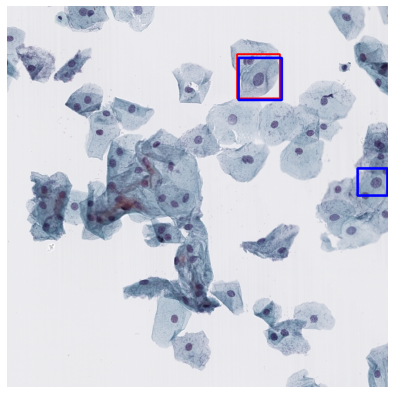

In [22]:
from visualize import visualize
IMAGE_NUM = 0
image = images[IMAGE_NUM].numpy()
image = np.transpose(image, (1, 2, 0))
img_id = targets[IMAGE_NUM]['image_id'].item()
img_path = df[df['ID']==img_id].file_name.values[0]
print(img_path)
ground_boxes = targets[IMAGE_NUM]['boxes']
print(len(ground_boxes))
out_boxes = outputs[IMAGE_NUM]['boxes']
out_scores = outputs[IMAGE_NUM]['scores']
print(out_scores)
# print(out_boxes)

pred_boxes = []
for b, s in zip(out_boxes, out_scores) :
    if s > 0.3 :
        pred_boxes.append(b.numpy())
print(pred_boxes)        

visualize(image, ground_boxes, pred_boxes)        

In [80]:
df[df['file_name'] == 'patch_images/2021.01.12/LBC308-20210108(1)/LBC308-20210108(1)_1445.png']

,ID,file_name,task,bbox,xmin,ymin,w,h,label,occluded,des,cell_type,label_id
1838,1412,patch_images/2021.01.12/LBC308-20210108(1)/LBC...,[ASCUS] LBC308,"[810, 1133, 115, 320]",810,1133,115,320,Carcinoma,0,NaN,Candida albicans,1.0


In [24]:
targets

({'boxes': tensor([[378.5000, 438.0000, 468.0000, 507.5000]]),
  'labels': tensor([1]),
  'image_id': tensor([7218]),
  'area': tensor([24881.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[708.5000, 752.5000, 768.0000, 815.0000]]),
  'labels': tensor([1]),
  'image_id': tensor([4308]),
  'area': tensor([14875.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[236.5000, 919.5000, 337.0000, 994.5000]]),
  'labels': tensor([1]),
  'image_id': tensor([986]),
  'area': tensor([30150.]),
  'iscrowd': tensor([0])},
 {'boxes': tensor([[126.5000, 229.5000, 250.5000, 381.0000]]),
  'labels': tensor([1]),
  'image_id': tensor([4015]),
  'area': tensor([75144.]),
  'iscrowd': tensor([0])})